In [51]:
# import metrics
import os
import math
import random
import time
from PIL import Image

import torch # pytorch의 tensor와 그와 관련된 기본 연산 등을 지원
import torch.nn as nn # 여러 딥러닝 layer와 loss, 함수 등을 클래스 형태로 지원
import torch.nn.functional as F # 여러 loss, 함수 등을 function 형태로 지원
import torch.optim as optim # 여러 optimizer를 지원
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as T # 이미지 전처리를 지원

dev = 'cuda' if torch.cuda.is_available() else 'cpu'

# GPU 선택
os.environ['CUDA_VISIBLE_DEVICES']='1'

### CosFace

![Architecture](img/Cosface.PNG)

ArcFace와 비슷한 모델 중 하나로 CosFace라는 모델이 있습니다. 위 Loss function은 CosFace의 loss function에 해당합니다. 위 loss function을 참고하여 아래의 ??? 부분을 채워주세요.

In [52]:
class CosMarginProduct(nn.Module):
    '''
    목적 : Cosface 의 last fc layer의 구현
    
    인자 :
    in_features : feature의 dimension
    out_features : class 개수
    '''
    def __init__(self, in_features, out_features, s=30.0, m=0.1):
        super(CosMarginProduct, self).__init__()        
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        # fc의 parameter 만들기 : (in_features x out_features)의 크기를 갖는 FloatTensor로 만들 것
        self.weight = torch.nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        '''
        Step 1. cos(theta)-m 계산하기
        '''

        # cos_theta = (x / ||x||) * (w * ||w||) 를 이용해 cosine_theta 구하기
        cos = torch.mm(F.normalize(input, dim=1), F.normalize(self.weight, dim=0))
        
        # cos_theta - m 구하기
        cos_m = cos - self.m
        
        '''
        Step 2. cos(theta)-m 에서 dim=1에 대해 y_i에 해당하는 부분만 남기고 나머지는 cos(theta)로 되돌리기 
        '''
        one_hot = torch.zeros(cos.size()).to(dev)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * cos_m) + ((1.0 - one_hot) * cos)
        
        '''
        Step 3. 최종 output 계산하기
        '''
        output *= self.s
        
        return output

### SphereFace

![Architecture](img/Sphereface.PNG)

ArcFace와 비슷한 모델 중 하나로 SphereFace 모델이 있습니다. 위 Loss function은 SphereFace의 loss function에 해당합니다. 위 loss function을 참고하여 아래의 ??? 부분을 채워주세요.

In [53]:
class SphereMarginProduct(nn.Module):
    '''
    목적 : Sphereface의 last fc layer의 구현
    
    인자 :
    in_features : feature의 dimension
    out_features : class 개수
    '''
    def __init__(self, in_features, out_features, m=4):
        super(SphereMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.m = m
        
        # fc의 parameter 만들기 (dimension은 (in_features x out_features))
        self.weight = torch.nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        '''
        Step 1. cos(m * theta) 계산하기
        '''

        # cos_theta = (x / ||x||) * (w * ||w||) 를 이용해 cosine_theta 구하기
        cos = F.linear(F.normalize(input), F.normalize(self.weight))
        
        # cos(m * theta) 구하기. 논문에서 m=4로 제시하고 있으므로 m=4 일 경우에 대해서만 계산합니다.
        # 효율성을 위해 arccos 등의 다른 연산 없이 위에서 얻은 cos만을 사용해 계산합니다.
        cos_m = 1 - 8*(cos**2) + 8*(cos**4)
        
        '''
        Step 2. cos(m * theta) 에서 dim=1에 대해 y_i에 해당하는 부분만 남기고 나머지는 cos(theta)로 되돌리기 
        '''
        one_hot = torch.zeros(cos.size()).to('cpu')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        
        output = (one_hot * cos_m) + ((1.0 - one_hot) * cos)

        '''
        Step 3. 최종 output 계산하기
        '''
        '''
        ########################## 둘 다 맞아야 1개로 인정 ###########################
        '''
        x_norm = torch.norm(input, p='fro', dim=1)
        output *= x_norm.unsqueeze(dim=1)
        return output


### Backbone network

ResNet-101을 이용하여 Backbone network를 구현합니다. 아래 코드의 ??? 부분을 채워주세요.

In [54]:
class FeatureNet_101(nn.Module):
    def __init__(self, dim_feature):
        super(FeatureNet_101, self).__init__()
        resnet = models.resnet101(pretrained=False)

        self.backbone = nn.Sequential(* list(resnet.children())[0:-2])
        self.bn_4 = nn.BatchNorm2d(2048)
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(2048 * 4 * 4, dim_feature)
        self.bn_5 = nn.BatchNorm1d(dim_feature)
        
    def forward(self, x):
        out = self.backbone(x)
        out = self.bn_4(out)
        out = self.dropout(out)
        out = out.view(out.size(0), -1)

        out = self.fc(out)
        out = self.bn_5(out)
        return out

### FaceNet

위에서 구현한 각 모델의 마지막 FC layer들과 Backbone network를 합쳐서 하나의 얼굴인식모델을 만듭니다.
아래 코드의 ??? 부분을 채워주세요.

In [55]:
class FaceNet(nn.Module):
    '''
    ArcMarginProduct와 FeatureNet-18 을 결합한 ArcFace 모델의 구현
    '''
    def __init__(self, feature_dim, cls_num, model_type='Cosface'):
        super(FaceNet, self).__init__()
        self.feature_net = FeatureNet_101(feature_dim)
        
        if model_type == 'Cosface':
            self.classifier = CosMarginProduct(feature_dim, cls_num)
        elif model_type == 'Sphereface':
            self.classifier = SphereMarginProduct(feature_dim, cls_num)

    # 끝까지 Forward 하여 logit을 return
    '''
    ########################## 둘 다 맞아야 1개로 인정 ###########################
    '''
    def forward(self, x, label):
        out = self.feature_net(x)
        out = self.classifier(out, label)
        return out
    
    # Feature만 return
    def extract_feature(self, x):
        out = self.feature_net(x)
        return out

In [56]:
# 두 input 이미지의 유사도를 측정하는데 사용되는 cosine similarity

def cos_dist(x1, x2):
    return torch.sum(x1 * x2) / (torch.norm(x1) * torch.norm(x2))

### FaceNet

FaceNet을 이용하여 두 input 사이의 similarity를 계산합니다.

In [57]:
# 두 input입니다.
x_1 = torch.randn(1, 3, 128, 128).to(dev)
x_2 = torch.randn(1, 3, 128, 128).to(dev)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


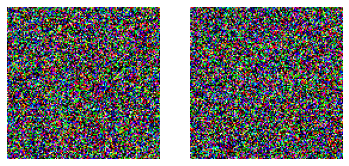

In [58]:
plt.subplot(121)
plt.axis('off')
plt.imshow(x_1.cpu()[0].permute((1,2,0)))

plt.subplot(122)
plt.axis('off')
plt.imshow(x_2.cpu()[0].permute((1,2,0)))

In [ ]:
# 각 model을 만듭니다. 이 모델에서 사용하는 feature의 dim은 512고 class는 총 1000개가 있습니다.
SphereFaceNet = FaceNet(feature_dim=512, cls_num=1000, model_type='Sphereface').to(dev)
CosFaceNet = FaceNet(feature_dim=512, cls_num=1000, model_type='Cosface').to(dev)

# test를 위해 model을 test phase로 변경합니다.
SphereFaceNet.eval()
CosFaceNet.eval()

# x_1, x_2로부터 SphereFace 모델을 이용해 feature를 추출합니다.
feature_1 = SphereFaceNet.extract_feature(x_1)
feature_2 = SphereFaceNet.extract_feature(x_2)

# 두 feature의 유사도를 계산합니다.
sim = cos_dist(feature_1, feature_2)
print('SphereFace에서 두 input의 유사도는 %f 입니다.' % sim.item())

In [ ]:
# x_1, x_2로부터 CosFace 모델을 이용해 feature를 추출합니다.
feature_1 = CosFaceNet.extract_feature(x_1)
feature_2 = CosFaceNet.extract_feature(x_2)

# 두 feature의 유사도를 계산합니다.
sim = cos_dist(feature_1, feature_2)
print('CosFace에서 두 input의 유사도는 %f 입니다.' % sim.item())

In [59]:
# x_1, x_2로부터 CosFace 모델을 이용해 feature를 추출합니다.
feature_1 = CosFaceNet.extract_feature(x_1)
feature_2 = CosFaceNet.extract_feature(x_2)

# 두 feature의 유사도를 계산합니다.
sim = cos_dist(feature_1, feature_2)
print('CosFace에서 두 input의 유사도는 %f 입니다.' % sim.item())

SphereFace에서 두 input의 유사도는 0.999753 입니다.


In [60]:
# x_1, x_2로부터 CosFace 모델을 이용해 feature를 추출합니다.
feature_1 = CosFaceNet.extract_feature(x_1)
feature_2 = CosFaceNet.extract_feature(x_2)

# 두 feature의 유사도를 계산합니다.
sim = cos_dist(feature_1, feature_2)
print('CosFace에서 두 input의 유사도는 %f 입니다.' % sim.item())

CosFace에서 두 input의 유사도는 0.999420 입니다.
